# Estimating Option Prices with Heston’s Stochastic Volatility Model


In [ ]:
#import the needed packages
import numpy as np
import pandas_datareader as web
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
from sklearn import metrics
import scipy.stats as st
import scipy.integrate as integrate
import datetime as datetime
import seaborn as sns
import scipy.optimize as opt
from math import log, sqrt, pi, exp
from scipy.stats import norm
from scipy.stats import moment
!pip install yahoo_fin
from yahoo_fin import options
!pip install requests_cache
import requests_cache
import statistics
import pdb
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 8.4 MB/s 
     |████████████████████████████████| 83 kB 2.1 MB/s 
     |████████████████████████████████| 127 kB 66.2 MB/s 
     |████████████████████████████████| 112 kB 64.1 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=f226f236131dd9f6a9f081104f127a0d610a9aa09085a5aff8e0723d1765059b
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=7ab4bb5a6bce1e8fb385e4f1fd5708b8c1dc99a97a672056f884c85086d6ad07
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=2e1568fad33372b0a21eb9cd3f6e5b4ca834b486a235020fa196c

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 3.5 MB/s 


The daily data for the S&P100 in the date interval between January 2nd 1991 and June 11th 1997 is retrieved from Yahoo Finance.

In [ ]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0', 'Accept': 'application/json;charset=utf-8'}


#dataset for parameter estimation with MLE and MOM

sp100= web.DataReader('^sp100', data_source='yahoo', start="1991-01-02", end ="1997-06-11", session = session)
sp100.head(5) 
sp100.tail(5)      


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1997-06-05,414.274994,410.184998,410.184998,411.420013,905220000,411.420013
1997-06-06,419.760010,411.309998,411.420013,418.579987,977880000,418.579987
1997-06-09,422.429993,418.579987,418.579987,421.209991,931620000,421.209991
1997-06-10,424.640015,420.015015,421.209991,421.750000,1053960000,421.750000
1997-06-11,424.390015,421.644989,421.750000,423.950012,1027480000,423.950012


In [ ]:
    #create a new dataframe with only the Adjusted closing prices from the starting dataframe

price = sp100['Adj Close']
price.head(5)

Date
1991-01-02    153.360001
1991-01-03    151.440002
1991-01-04    151.279999
1991-01-07    148.529999
1991-01-08    148.149994
Name: Adj Close, dtype: float64

In [ ]:
# load data set for option price comparison
comparison_df = pd.read_csv("/content/Option price comparison - Sheet1.csv")
comparison_df.head(5)

FileNotFoundError: ignored

## Base case: Black-Scholes

In [ ]:
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)
def bs_call(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

In [ ]:
# test values from paper
sig = 0.00723
rf = 0.0485

In [ ]:
# create new column in comparison table
comparison_df["BS-call"] = np.nan

NameError: ignored

In [ ]:
for i in range(len(comparison_df.index)):
  comparison_df['BS-call'][i] = bs_call(S = comparison_df['Stock price'][i], K = comparison_df['Strike price'][i], T = comparison_df['Expiration'][i]/252, r = rf, sigma = sig)

In [ ]:
comparison_df.head(5)

## Method of Moments Estimates

In [ ]:
def moments(data,moment_nr):
    length = len(data)
    moment = 1/length * (np.sum(data**moment_nr))
    return moment


In [ ]:
rets = np.zeros(len(price)-1)

In [ ]:
#Calculate return
for i in range(1,len(price)):
 rets[i-1] = price[i]/price[i-1]
rets[:5]
rets.std() #paper around 0.00723

0.007215028827762532

In [ ]:
#Obtain sample moments
moment_1 = moments(rets,1)
moment_2 = moments(rets,2)
moment_4 = moments(rets,4)
moment_5 = moments(rets,5)

In [ ]:
moment_4, moment_5

(1.0029169238789952, 1.0037778651229008)

In [ ]:
from scipy.optimize import fsolve

In [ ]:
# Calculate the parameters
r_MOM = moment_1-1
theta_MOM = moment_2 - (r_MOM + 1)**2
r_MOM, theta_MOM
rho_MOM = 0

In [ ]:
#def fun(variables) :
#    (k,sig)= variables
#    eqn_1 = 1/(k*(k-2))*((k**2)*(r_mom**4) + 4*(k**2)*(r_mom**3) + 6*(k**2)*(r_mom**2)*theta_mom - 2*k*(r_mom**4) + 6*(k**2)*(r_mom**2) + 12*(k**2)*r_mom*theta_mom + 3*(k**2)*(theta_mom**2) - 8*k*(r_mom**3) - 12*k*(r_mom**2)*theta_mom + 4*(k**2)*r_mom + 6*(k**2)*theta_mom - 12*k*(r_mom**2) -24*k*r_mom*theta_mom -6*k*(theta_mom**2) - 3*(sig**2) * theta_mom + (k**2) - 8*k*r_mom - 12*k*theta_mom -2*k) - moment_4
#    eqn_2 = 1/(k*(k-2))*((k**2)*(r_mom**5)+5*(k**2)*(r_mom**4)+10*(k**2)*(r_mom**3)*theta_mom-2*k*(r_mom**5)+10*(k**3)*(r_mom**3)+30*(k**2)*(r_mom**2)*theta_mom+15*(k**2)*r_mom*(theta_mom**2)-10*k*(r_mom**4)-20*k*(r_mom**3)*theta_mom+10*(k**2)*(r_mom**2)+30*(k**2)*r_mom*theta_mom+15*(k**2)*(theta_mom**2)-20*k*(r_mom**3)-60*k*(r_mom**2)*theta_mom-30*k*r_mom*(theta_mom**2)-15*r_mom*(sig**2)*theta_mom+5*(k**2)*r_mom+10*(k**2)*theta_mom-20*k*(r_mom**2)-60*k*r_mom*theta_mom-30*k*(theta_mom**2)-15*(sig**2)*theta_mom+(k**2)-10*k*r_mom-20*k*theta_mom-2*k)-moment_5
#    return [eqn_1,eqn_2]
#result = fsolve(fun, (-2,-2)) 
#print(result)

In [ ]:
#a = np.array([1, 2])
#np.append(a, 1)

In [ ]:
### check more solutions

#solutions = np.empty(2)

#for i in np.arange(-5, 5, 0.25):
#  for j in np.arange(-5, 5, 0.25):
#    solutions = np.vstack([solutions, fsolve(fun, (i,j))])

In [ ]:
#solutions[:,0].mean()

In [ ]:
#def equations(vars):
#    k, sig = vars
#    eq1 = 1/(k*(k-2))*((k**2)*(r_mom**4) + 4*(k**2)*(r_mom**3) + 6*(k**2)*(r_mom**2)*theta_mom - 2*k*(r_mom**4) + 6*(k**2)*(r_mom**2) + 12*(k**2)*r_mom*theta_mom + 3*(k**2)*(theta_mom**2) - 8*k*(r_mom**3) - 12*k*(r_mom**2)*theta_mom + 4*(k**2)*r_mom + 6*(k**2)*theta_mom - 12*k*(r_mom**2) -24*k*r_mom*theta_mom -6*k*(theta_mom**2) - 3*(sig**2) * theta_mom + (k**2) - 8*k*r_mom - 12*k*theta_mom -2*k) - moment_4
#    eq2 = 1/(k*(k-2))*((k**2)*(r_mom**5)+5*(k**2)*(r_mom**4)+10*(k**2)*(r_mom**3)*theta_mom-2*k*(r_mom**5)+10*(k**3)*(r_mom**3)+30*(k**2)*(r_mom**2)*theta_mom+15*(k**2)*r_mom*(theta_mom**2)-10*k*(r_mom**4)-20*k*(r_mom**3)*theta_mom+10*(k**2)*(r_mom**2)+30*(k**2)*r_mom*theta_mom+15*(k**2)*(theta_mom**2)-20*k*(r_mom**3)-60*k*(r_mom**2)*theta_mom-30*k*r_mom*(theta_mom**2)-15*r_mom*(sig**2)*theta_mom+5*(k**2)*r_mom+10*(k**2)*theta_mom-20*k*(r_mom**2)-60*k*r_mom*theta_mom-30*k*(theta_mom**2)-15*(sig**2)*theta_mom+(k**2)-10*k*r_mom-20*k*theta_mom-2*k)-moment_5
#    return [eq1, eq2]

#k, sig =  fsolve(equations, (1, 1))
#print(k, sig)

In [ ]:
def equations(vars):
    k, sig = vars
    eq1 = ((k**2)*(r_MOM**4) + 4*(k**2)*(r_MOM**3) + 6*(k**2)*(r_MOM**2)*theta_MOM - 2*k*(r_MOM**4) + 6*(k**2)*(r_MOM**2) + 12*(k**2)*r_MOM*theta_MOM + 3*(k**2)*(theta_MOM**2) - 8*k*(r_MOM**3) - 12*k*(r_MOM**2)*theta_MOM + 4*(k**2)*r_MOM + 6*(k**2)*theta_MOM - 12*k*(r_MOM**2) -24*k*r_MOM*theta_MOM -6*k*(theta_MOM**2) - 3*(sig**2) * theta_MOM + (k**2) - 8*k*r_MOM - 12*k*theta_MOM -2*k) - moment_4*(k**2 - 2*k)
    eq2 = ((k**2)*(r_MOM**5)+5*(k**2)*(r_MOM**4)+10*(k**2)*(r_MOM**3)*theta_MOM-2*k*(r_MOM**5)+10*(k**3)*(r_MOM**3)+30*(k**2)*(r_MOM**2)*theta_MOM+15*(k**2)*r_MOM*(theta_MOM**2)-10*k*(r_MOM**4)-20*k*(r_MOM**3)*theta_MOM+10*(k**2)*(r_MOM**2)+30*(k**2)*r_MOM*theta_MOM+15*(k**2)*(theta_MOM**2)-20*k*(r_MOM**3)-60*k*(r_MOM**2)*theta_MOM-30*k*r_MOM*(theta_MOM**2)-15*r_MOM*(sig**2)*theta_MOM+5*(k**2)*r_MOM+10*(k**2)*theta_MOM-20*k*(r_MOM**2)-60*k*r_MOM*theta_MOM-30*k*(theta_MOM**2)-15*(sig**2)*theta_MOM+(k**2)-10*k*r_MOM-20*k*theta_MOM-2*k) - moment_5*(k**2 - 2*k)
    return [eq1, eq2]

k_MOM, sigma_MOM =  fsolve(equations, (1, 1))
print(k_MOM, sigma_MOM)
  

2.054093186327272 0.005139313373595587


In [ ]:
equations([k_MOM, sigma_MOM])

[4.163336342344337e-17, 5.551115123125783e-17]

In [ ]:
# Using parameters from paper
k = 2
sig = 2.38e-3
equations([k, sig])

[-8.846088306313504e-10, 6.580224365393406e-09]

## Maximum Likelihood Estimates


In [ ]:
rets_pd = pd.DataFrame(rets)
V = rets_pd.expanding(1).var()
V = V.shift(-1).dropna()
V, rets_pd


(             0
 0     0.000066
 1     0.000076
 2     0.000067
 3     0.000056
 4     0.000118
 ...        ...
 1623  0.000052
 1624  0.000052
 1625  0.000052
 1626  0.000052
 1627  0.000052
 
 [1628 rows x 1 columns],              0
 0     0.987480
 1     0.998943
 2     0.981822
 3     0.997442
 4     0.985859
 ...        ...
 1624  1.003011
 1625  1.017403
 1626  1.006283
 1627  1.001282
 1628  1.005216
 
 [1629 rows x 1 columns])

In [ ]:
def negloglik(pars, Q, V):
    n = len(V)
    r, k, theta, sigma, rho = pars
    logL = 0
    for i in range(n - 1):
      logL = - log(2*pi) - log(sigma) - log(V[i]) - 0.5*log(1 - (rho**2)) - ((Q[i+1] - 1 -  r)**2)/(2*V[i]*(1 - rho**2)) + (rho*(Q[i+1] - 1 - r)*(V[i+1] - V[i] - theta*k + k*V[i]))/(V[i]*sigma*(1 - rho**2)) - ((V[i+1] - V[i] - theta*k + k*V[i])**2)/(2*(sigma**2)*V[i]*(1 - rho**2))
      logL += logL
      neg_logL = -logL
    return neg_logL

def MLE(pars0, Q, V, par_bounds):
  results =  opt.minimize(negloglik, pars0, args = (Q, V), bounds = par_bounds, method='L-BFGS-B', tol=1e-8)
  r, k, theta , sigma, rho = results.x
  loglik = -results.fun
  return r, k, theta, sigma, rho, loglik

#using returns instead of rets since V is based on returns
# Results from paper
pars_paper = np.array([6.40e-4, 6.57e-3, 6.47e-5, 5.09e-4, -1.98e-3])

# Initial parameters
ini_pars = np.array([0.01, 0.01, 0.01, 0.01, -0.5])

# Parameters Constrains
par_bounds = np.array([(None, None), (0, None), (0, None), (0.0001, None), (-0.999, 1)]) # correlation in [-1, 1]

print("The value of the loglik function from the paper is:", -negloglik(pars_paper, rets, pd.DataFrame.to_numpy(V))) # ~ -31.206095
mle_models = MLE(ini_pars, rets,  pd.DataFrame.to_numpy(V), par_bounds)
# Results 
pd.DataFrame({'Param': ['r', 'k', 'theta', 'sigma', 'rho', 'loglik'], 'Value': mle_models})




The value of the loglik function from the paper is: [31.20609567]


,Param,Value
0,r,0.001283
1,k,0.010477
2,theta,0.00005
3,sigma,0.0001
4,rho,-0.500098
5,loglik,[34.757130228355166]


In [ ]:
[r_MLE, k_MLE, theta_MLE, sigma_MLE, rho_MLE, loglik_MLE] = mle_models
[r_in, k_in, theta_in, sigma_in, rho_in] = pars_paper
[r_MOM, k_MOM, theta_MOM, sigma_MOM, rho_MOM]= np.array([0.000650416809823362, 4.163336342344337e-17, 5.205664098562046e-05,.551115123125783e-17, -1])

In [ ]:
def heston_f(x, tau, r, k, S, rho, V, theta, sigma):
    
    phi = x.imag
    #prod = rho * sigma *1j*phi 
    prod = rho * sigma * x 
    
    #compute M
    M = np.sqrt((prod - k)**2 + sigma**2 * (x + phi**2))
    
    #compute N 
    n1 = prod - k - M
    n2 = prod - k + M
    N = n1/n2
    A = r*x*tau + (k*theta)/(sigma**2) * (-n1*tau - 2*np.log((1 - N* np.exp(M*tau))/(1-N)))
    #B = 0
    C = ((np.exp(M*tau) - 1) * n1) / ((sigma**2) * (1 - N*np.exp(M*tau)))
    #f = np.exp(A + B*log(S) + C*V + 1j*phi*log(S)) #=log(S)
    f = np.exp(A + C*V + x*S) #=log(S)
    return f


def heston_call(tau, r, k, S, K, rho, V, theta, sigma):
  arguments = (tau, r, k, np.log(S), K, rho, V, theta, sigma)

  #first integrand 
  def integrand1(phi, tau, r, k, S, K, rho, V, theta, sigma):
    #int1= (lambda phi: np.real((K**(-1j*phi)*heston_f(phi,tau,r,k,S,rho,V,theta,sigma)/(1j*phi))))
    #int1 = np.real((np.exp(-1j*phi*np.log(K))*heston_f(phi,tau,r,k,S,rho,V,theta,sigma))/(1j*phi))
    int1 = np.real((K**(-1j*phi) * heston_f(1+1j*phi,tau,r,k,S,rho,V,theta,sigma))/(1j*phi))
    return int1

  part1 = integrate.quad(integrand1, 0, 1e4, arguments)[0]
 
  #second integrand
  def integrand2(phi, tau, r, k, S, K, rho, V, theta, sigma):
    #phi2 = phi + (1/1j) #since 1j*(phi+1/1j)/=1j*phi + 1 #this is probably wrong
    #int2 = (lambda phi: np.real((K**(-1j*phi)*heston_f(phi2,tau,r,k,S,rho,V,theta,sigma)/(1j*phi))))
    int2 =  np.real((K**(-1j*phi) * heston_f(1j*phi,tau,r,k,S,rho,V,theta,sigma))/(1j*phi))
    return int2

  part2 = integrate.quad(integrand2, 0, 1e4, arguments)[0]
   
  call = 0.5*S + (np.exp(-r*tau)/np.pi)*part1 - K*np.exp(-r*tau)*(0.5 + (1/np.pi)* part2)
  return call


#try with first row of table
K = 395
tau = 24
S = 425.73
[r_in, k_in, theta_in, sigma_in, rho_in] = np.array([6.40e-4, 6.57e-3, 6.47e-5, 5.09e-4, -1.98e-3])

call_paper = heston_call(tau/365, r_in, k_in, S, K, rho_in, V.iloc(1)[1627,0], theta_in, sigma_in)
# 30.74625756542713

#with out parameters
call_replication = heston_call(tau/365, r_MLE, k_MLE, S, K, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
#30.762948091890905

call_paper,call_replication

(30.746257565427243, 30.76294809204228)

In [ ]:
##################     MLE HESTON ESTIMaTION WITH DIFFERENT PARAMS   #######################

##################                          24                       #######################
#K=395
heston_call(tau/365, r_MLE, k_MLE, S, K, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
#30.762948091890905
#K=400
heston_call(tau/365, r_MLE, k_MLE, S, K, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
#25.763369770602708
#K=405
heston_call(tau/365, r_MLE, k_MLE, S, 405, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
#20.763791449313146

##################                          87                        #######################
#tau = 87, K = 380
heston_call(87/365, r_MLE, k_MLE, S, 380, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
#45.84483826886674

#tau = 87, K  = 385
heston_call(87/365, r_MLE, k_MLE, S, 385, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
# 40.84636668501054

#tau = 87,K = 390
heston_call(87/365, r_MLE, k_MLE, S, 390, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
#35.847895101161384

##################                          115                        #######################
#tau = 115, K = 380
heston_call(115/365, r_MLE, k_MLE, S, 380, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
#45.88179018787156

#tau = 115, K = 390
heston_call(115/365, r_MLE, k_MLE, S, 390, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
# 35.885830629502664

#tau = 115, K = 400
heston_call(115/365, r_MLE, k_MLE, S, 400, rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE)
#25.85095193345353



25.889871071856362

In [ ]:
#create list of strikes for the maturities
list_K_24 = range(395,455, 5) #last value in range is not included so 460 means last value is 455
list_K_87 = range(380,460, 5)
list_K_115 = range(380,460, 10)

list_stock_price_24 = np.array([425.73,425.73,425.73,425.67, 425.68,425.65,425.65,425.68,425.65,425.16,424.78,425.19])
list_stock_price_87 = np.array([425.73,425.73,425.73,425.73, 425.73,425.73,425.26,425.86,425.68,425.42,425.62,425.82,425.68,425.75,425.78,425.39])
list_stock_price_115 = np.array([425.73,425.73,425.73,425.73, 425.42,425.64,425.28,425.13])

In [ ]:

storage_BS_24 = np.zeros(len(list_K_24))
storage_BS_87 = np.zeros(len(list_K_87))
storage_BS_115 = np.zeros(len(list_K_115))
# test values from paper
sig = 0.00723
rf = 0.0485
for i in range(len(list_K_24)):
  storage_BS_24[i] = bs_call(list_stock_price_24[i], list_K_24[i],24/252, r= rf, sigma  =sig)
for i in range(len(list_K_87)):
  storage_BS_87[i] = bs_call(list_stock_price_87[i], list_K_87[i],87/252, r= rf, sigma  =sig)
for i in range(len(list_K_115)):
  storage_BS_115[i] = bs_call(list_stock_price_115[i], list_K_115[i],115/252, r= rf, sigma  =sig)



Compute Heston Prices with estimated Parameters

In [ ]:
#compute heston prices with MOM params for different maturities and strikes

storage_MOM_24 = np.zeros(len(list_K_24))
storage_MOM_87 = np.zeros(len(list_K_87))
storage_MOM_115 = np.zeros(len(list_K_115))

for i in range(len(list_K_24)):
  storage_MOM_24[i] = max(heston_call(24/365, r_MOM, k_MOM, list_stock_price_24[i], list_K_24[i], rho_MOM, V.iloc(1)[1627,0], theta_MOM, sigma_MOM),0)
for i in range(len(list_K_87)):
  storage_MOM_87[i] = max(heston_call(87/365, r_MOM, k_MOM, list_stock_price_87[i], list_K_87[i], rho_MOM, V.iloc(1)[1627,0], theta_MOM, sigma_MOM),0)
for i in range(len(list_K_115)):
  storage_MOM_115[i] = max(heston_call(115/365, r_MOM, k_MOM, list_stock_price_115[i], list_K_115[i], rho_MOM, V.iloc(1)[1627,0], theta_MOM, sigma_MOM),0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a

In [ ]:
#compute heston prices with MLE params for different maturities and strikes

storage_MLE_24 = np.zeros(len(list_K_24))
storage_MLE_87 = np.zeros(len(list_K_87))
storage_MLE_115 = np.zeros(len(list_K_115))

for i in range(len(list_K_24)):
  storage_MLE_24[i] = max(heston_call(24/365, r_MLE, k_MLE, list_stock_price_24[i], list_K_24[i], rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE),0)
for i in range(len(list_K_87)):
  storage_MLE_87[i] = max(heston_call(87/365, r_MLE, k_MLE, list_stock_price_87[i], list_K_87[i], rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE),0)
for i in range(len(list_K_115)):
  storage_MLE_115[i] = max(heston_call(115/365, r_MLE, k_MLE, list_stock_price_115[i], list_K_115[i], rho_MLE, V.iloc(1)[1627,0], theta_MLE, sigma_MLE),0)


In [ ]:
strikes = [*list(list_K_24),*list(list_K_87),*list(list_K_115)]
stock_prices_tab = np.concatenate([list_stock_price_24.flatten(),list_stock_price_87.flatten(),list_stock_price_115.flatten()])
actual_prices = [30.75,25.88, 21.00, 16.50,11.88,7.69,4.44,2.10,0.78
                 ,0.25,0.10,0.1,46.75,42,37.50,33.00,28.5, 24.13, 20.38,
                 16.13,12.82, 9.32,6.51, 4.51, 2.75,1.6,0.85,0.44,
                 47.25,38.13,29.38,21.19,13.88,8.13,3.88,1.5]
prices_BS = np.round(np.concatenate([storage_BS_24.flatten(),storage_BS_87.flatten(),storage_BS_115.flatten()]),4)

prices_MOM = np.round(np.concatenate([storage_MOM_24.flatten(),storage_MOM_87.flatten(),storage_MOM_115.flatten()]),4)

prices_MLE = np.round(np.concatenate([storage_MLE_24.flatten(),storage_MLE_87.flatten(),storage_MLE_115.flatten()]),4)

pd.DataFrame({'Strike':strikes
              ,'Stock': stock_prices_tab
              ,'Actual Price':actual_prices
              , 'MOM Heston Price': prices_MOM
              , 'MLE Heston Price': prices_MLE
              , 'BS Price':prices_BS})


,Strike,Stock,Actual Price,MOM Heston Price,MLE Heston Price,BS Price
0,395,425.73,30.75,32.0735,30.7629,32.5503
1,400,425.73,25.88,25.3615,25.7634,27.5734
2,405,425.73,21.00,21.7092,20.7638,22.5964
3,410,425.67,16.50,16.1976,15.7042,17.5594
4,415,425.68,11.88,10.5889,10.7146,12.5925
5,420,425.65,7.69,4.6119,5.6851,7.5855
6,425,425.65,4.44,0.5442,0.5540,2.6094
7,430,425.68,2.10,0.6408,0.0004,0.0022
8,435,425.65,0.78,0.3039,0.0004,0.0000
9,440,425.16,0.25,1.4128,0.0004,0.0000


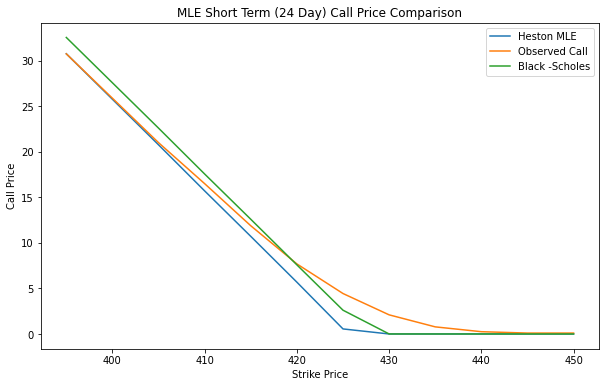

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(list(list_K_24),prices_MLE[0:12], label= "Heston MLE")
plt.plot(list(list_K_24),actual_prices[0:12], label = "Observed Call")
plt.plot(list(list_K_24),prices_BS[0:12], label = "Black -Scholes")
plt.title('MLE Short Term (24 Day) Call Price Comparison')
plt.legend()
plt.xlabel('Strike Price')
plt.ylabel('Call Price')
plt.show()

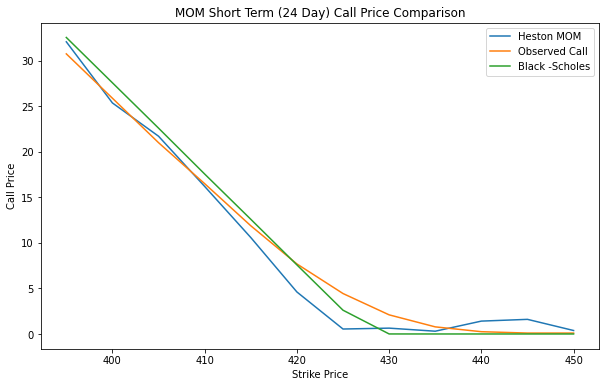

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(list(list_K_24),prices_MOM[0:12], label= "Heston MOM")
plt.plot(list(list_K_24),actual_prices[0:12], label = "Observed Call")
plt.plot(list(list_K_24),prices_BS[0:12], label = "Black -Scholes")
plt.title('MOM Short Term (24 Day) Call Price Comparison')
plt.legend()
plt.xlabel('Strike Price')
plt.ylabel('Call Price')
plt.show()

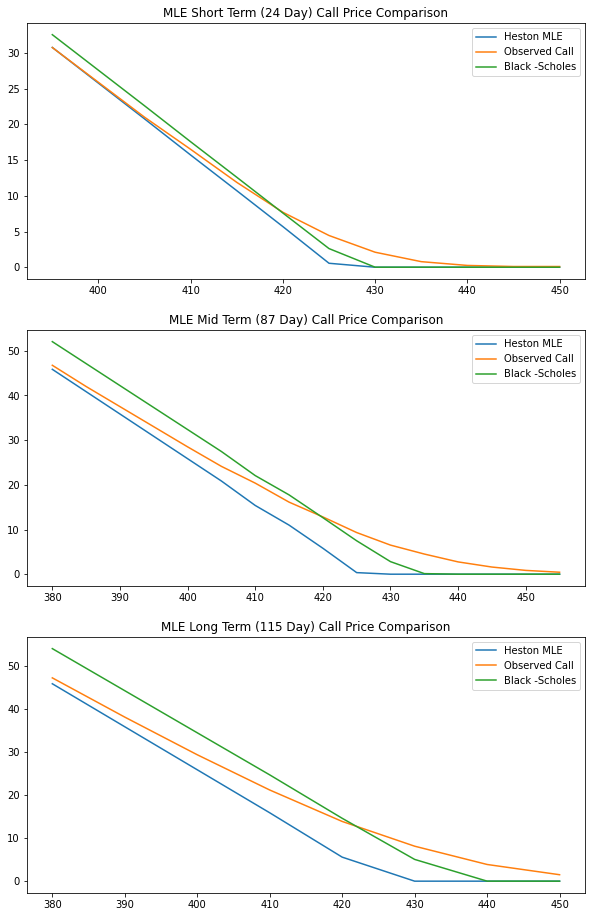

In [ ]:
#figure, axis = plt.subplots(1, 2)

plt.figure(figsize=(10,16))
axis1 = plt.subplot2grid((3, 1), (0, 0))
axis2 = plt.subplot2grid((3, 1), (1, 0))
axis3 = plt.subplot2grid((3, 1), (2, 0))

axis1.plot(list(list_K_24),prices_MLE[0:12], label= "Heston MLE")
axis1.plot(list(list_K_24),actual_prices[0:12], label = "Observed Call")
axis1.plot(list(list_K_24),prices_BS[0:12], label = "Black -Scholes")
axis1.set_title('MLE Short Term (24 Day) Call Price Comparison')

axis2.plot(list(list_K_87),prices_MLE[12:28], label= "Heston MLE")
axis2.plot(list(list_K_87),actual_prices[12:28], label = "Observed Call")
axis2.plot(list(list_K_87),prices_BS[12:28], label = "Black -Scholes")
axis2.set_title('MLE Mid Term (87 Day) Call Price Comparison')

axis3.plot(list(list_K_115),prices_MLE[28:], label= "Heston MLE")
axis3.plot(list(list_K_115),actual_prices[28:], label = "Observed Call")
axis3.plot(list(list_K_115),prices_BS[28:], label = "Black -Scholes")
axis3.set_title('MLE Long Term (115 Day) Call Price Comparison')

axis1.legend()
axis2.legend()
axis3.legend()
plt.show()

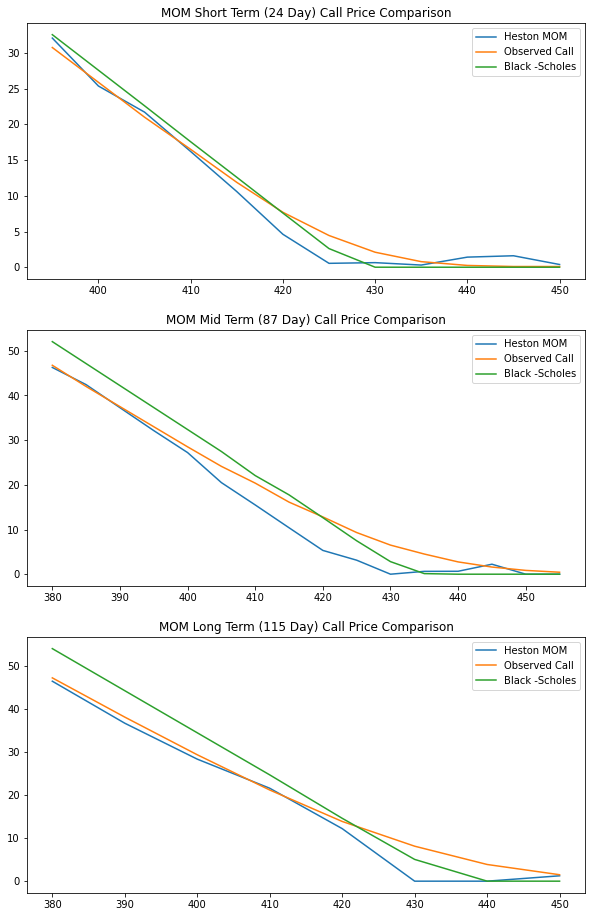

In [ ]:
plt.figure(figsize=(10,16))
axis1 = plt.subplot2grid((3, 1), (0, 0))
axis2 = plt.subplot2grid((3, 1), (1, 0))
axis3 = plt.subplot2grid((3, 1), (2, 0))

axis1.plot(list(list_K_24),prices_MOM[0:12], label= "Heston MOM")
axis1.plot(list(list_K_24),actual_prices[0:12], label = "Observed Call")
axis1.plot(list(list_K_24),prices_BS[0:12], label = "Black -Scholes")
axis1.set_title('MOM Short Term (24 Day) Call Price Comparison')

axis2.plot(list(list_K_87),prices_MOM[12:28], label= "Heston MOM")
axis2.plot(list(list_K_87),actual_prices[12:28], label = "Observed Call")
axis2.plot(list(list_K_87),prices_BS[12:28], label = "Black -Scholes")
axis2.set_title('MOM Mid Term (87 Day) Call Price Comparison')

axis3.plot(list(list_K_115),prices_MOM[28:], label= "Heston MOM")
axis3.plot(list(list_K_115),actual_prices[28:], label = "Observed Call")
axis3.plot(list(list_K_115),prices_BS[28:], label = "Black -Scholes")
axis3.set_title('MOM Long Term (115 Day) Call Price Comparison')

axis1.legend()
axis2.legend()
axis3.legend()
plt.show()

In [ ]:
#RMSE
#actual prices (observed)
actual_24 = actual_prices[0:12]
actual_87 = actual_prices[12:28]
actual_115 = actual_prices[28:]

#from BS
predicted_BS_24= prices_BS[0:12]
predicted_BS_87= prices_BS[12:28]
predicted_BS_115= prices_BS[28:]

rmse_BS_24 = math.sqrt(metrics.mean_squared_error(actual_24, predicted_BS_24))
rmse_BS_87 = math.sqrt(metrics.mean_squared_error(actual_87, predicted_BS_87))
rmse_BS_115 = math.sqrt(metrics.mean_squared_error(actual_115, predicted_BS_115))

#from MOM
predicted_MOM_24= prices_MOM[0:12]
predicted_MOM_87= prices_MOM[12:28]
predicted_MOM_115= prices_MOM[28:]

rmse_MOM_24 = math.sqrt(metrics.mean_squared_error(actual_24, predicted_MOM_24))
rmse_MOM_87 = math.sqrt(metrics.mean_squared_error(actual_87, predicted_MOM_87))
rmse_MOM_115 = math.sqrt(metrics.mean_squared_error(actual_115, predicted_MOM_115))

#from MLE
predicted_MLE_24= prices_MLE[0:12]
predicted_MLE_87= prices_MLE[12:28]
predicted_MLE_115= prices_MLE[28:]

rmse_MLE_24 = math.sqrt(metrics.mean_squared_error(actual_24, predicted_MLE_24))
rmse_MLE_87 = math.sqrt(metrics.mean_squared_error(actual_87, predicted_MLE_87))
rmse_MLE_115 = math.sqrt(metrics.mean_squared_error(actual_115, predicted_MLE_115))

print("RMSE for BS:",rmse_BS_24,rmse_BS_87,rmse_BS_115)
print("RMSE for MOM:",rmse_MOM_24,rmse_MOM_87, rmse_MOM_115)
print("RMSE for MLE:",rmse_MLE_24,rmse_MLE_87, rmse_MLE_115)

RMSE for BS: 1.2496947183879215 3.2942533843991115 4.323545830825666
RMSE for MOM: 1.7074531626079823 3.7953491481351223 3.313125297773992
RMSE for MLE: 1.4798610300745585 4.198280152708368 4.9916334365616235


##**Simulation**
###Simulation of Prices modelled with Heston for both MOM and MLE by Euler Discretization
Formula for the Euler Discretization Scheme for the Heston Model:

$$S_{t+1} = S_t + rS_t + \sqrt{V_t} S_tZ_s$$

$$V_{t+1} = V_t + k(θ − V_t) + σ\sqrt{V_t}Z_v$$

Code:

In [ ]:
def Heston_sim(S0, tau, r, k, theta, V0, rho, sigma, 
                          steps, Npaths):
    dt = tau/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    St = S0
    Vt = V0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths)
  
        Vt = np.abs(Vt + k*(theta-Vt)*dt + sigma*np.sqrt(Vt*dt)*WT[:,1])
        St = St + r*St*dt+ np.sqrt(Vt *dt)*St *WT[:,0] 
        prices[:, t] = St
        sigs[:, t] = Vt
    
    
    return prices

In [ ]:

sim_MLE = Heston_sim(price[0],1, r_MLE, k_MLE, theta_MLE, V.iloc(1)[1627,0], rho_MLE, sigma_MLE, 252, 10)
sim_MOM = Heston_sim(price[0],1, r_MOM, k_MOM, theta_MOM, V.iloc(1)[1627,0], rho_MOM, sigma_MOM, 252, 10)


**MOM**

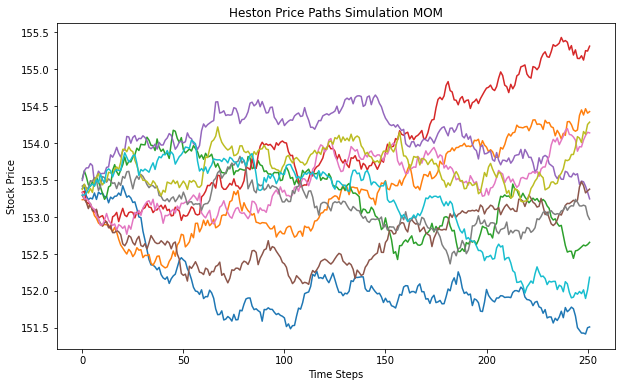

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(sim_MOM.T)
plt.title('Heston Price Paths Simulation MOM')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

**MLE**

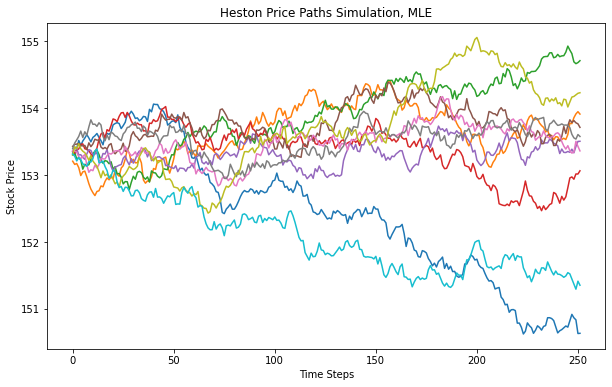

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(sim_MLE.T)
plt.title('Heston Price Paths Simulation, MLE')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

## Analysis with S\&P500
Extension of the analysis using a more recent time period (01 Januray 2005 to 01 December 2021) for S\&P500.

The 3 Month T-bill Closing Price is 0.056% .

In [ ]:
sp500= web.DataReader('^GSPC', data_source='yahoo', start="2015-01-01", end ="2021-12-01", session = session)
price500 = sp500['Adj Close']

#Calculate returns
rets500 = np.zeros(len(price500)-1)

for i in range(1,len(price500)):
 rets500[i-1] = price500[i]/price500[i-1]
rets500[:5]

sigmaBS500 =rets500.std() 
sigmaBS500 #0.011328474949025717

0.011328474949025717

In [ ]:
rets_pd500 = pd.DataFrame(rets500)
V500 = rets_pd500.expanding(1).var()
V500 = V500.shift(-1).dropna()
V500, rets_pd500
mle_models500 = MLE(ini_pars, rets500,  pd.DataFrame.to_numpy(V500), par_bounds)
# Results 
pd.DataFrame({'Param': ['r_MLE500', 'k_MLE500', 'theta_MLE500', 'sigma_MLE500', 'rho_MLE500', 'loglik_MLE500'], 'Value': mle_models500})



,Param,Value
0,r_MLE500,-0.031159
1,k_MLE500,0.000418
2,theta_MLE500,0.002669
3,sigma_MLE500,0.0001
4,rho_MLE500,-0.94666
5,loglik_MLE500,[33.68779678020186]


In [ ]:
#Obtain sample moments
moment_1_500 = moments(rets500,1)
moment_2_500 = moments(rets500,2)
moment_4_500 = moments(rets500,4)
moment_5_500 = moments(rets500,5)

# Calculate the parameters
r_MOM500 = moment_1-1
theta_MOM500 = moment_2 - (r_MOM + 1)**2
rho_MOM500 = 0


In [ ]:
def equations(vars):
    k, sig = vars
    eq1 = ((k**2)*(r_MOM500**4) + 4*(k**2)*(r_MOM500**3) + 6*(k**2)*(r_MOM500**2)*theta_MOM500 - 2*k*(r_MOM500**4) + 6*(k**2)*(r_MOM500**2) + 12*(k**2)*r_MOM500*theta_MOM500 + 3*(k**2)*(theta_MOM500**2) - 8*k*(r_MOM500**3) - 12*k*(r_MOM500**2)*theta_MOM500 + 4*(k**2)*r_MOM500 + 6*(k**2)*theta_MOM500 - 12*k*(r_MOM500**2) -24*k*r_MOM500*theta_MOM500 -6*k*(theta_MOM500**2) - 3*(sig**2) * theta_MOM500 + (k**2) - 8*k*r_MOM500 - 12*k*theta_MOM500 -2*k) - moment_4_500*(k**2 - 2*k)
    eq2 = ((k**2)*(r_MOM500**5)+5*(k**2)*(r_MOM500**4)+10*(k**2)*(r_MOM500**3)*theta_MOM500-2*k*(r_MOM500**5)+10*(k**3)*(r_MOM500**3)+30*(k**2)*(r_MOM500**2)*theta_MOM500+15*(k**2)*r_MOM500*(theta_MOM500**2)-10*k*(r_MOM500**4)-20*k*(r_MOM500**3)*theta_MOM500+10*(k**2)*(r_MOM500**2)+30*(k**2)*r_MOM500*theta_MOM500+15*(k**2)*(theta_MOM500**2)-20*k*(r_MOM500**3)-60*k*(r_MOM500**2)*theta_MOM500-30*k*r_MOM500*(theta_MOM500**2)-15*r_MOM500*(sig**2)*theta_MOM500+5*(k**2)*r_MOM500+10*(k**2)*theta_MOM500-20*k*(r_MOM500**2)-60*k*r_MOM500*theta_MOM500-30*k*(theta_MOM500**2)-15*(sig**2)*theta_MOM500+(k**2)-10*k*r_MOM500-20*k*theta_MOM500-2*k) - moment_5_500*(k**2 - 2*k)
    return [eq1, eq2]

k_MOM500, sigma_MOM500 =  fsolve(equations, (2, 2))
print(k_MOM500, sigma_MOM500)

2.0000108204771814 0.0034447367463995714


In [ ]:
#difference with the previous function is that here the limit of the iteratins is 100 instead of 50 (as default)
def heston_call2(tau, r, k, S, K, rho, V, theta, sigma):
  arguments = (tau, r, k, np.log(S), K, rho, V, theta, sigma)

  #first integrand 
  def integrand1(phi, tau, r, k, S, K, rho, V, theta, sigma):
    #int1= (lambda phi: np.real((K**(-1j*phi)*heston_f(phi,tau,r,k,S,rho,V,theta,sigma)/(1j*phi))))
    #int1 = np.real((np.exp(-1j*phi*np.log(K))*heston_f(phi,tau,r,k,S,rho,V,theta,sigma))/(1j*phi))
    int1 = np.real((K**(-1j*phi) * heston_f(1+1j*phi,tau,r,k,S,rho,V,theta,sigma))/(1j*phi))
    return int1

  part1 = integrate.quad(integrand1, 0, 1e4, arguments, limit = 100)[0]
 
  #second integrand
  def integrand2(phi, tau, r, k, S, K, rho, V, theta, sigma):
    #phi2 = phi + (1/1j) #since 1j*(phi+1/1j)/=1j*phi + 1 #this is probably wrong
    #int2 = (lambda phi: np.real((K**(-1j*phi)*heston_f(phi2,tau,r,k,S,rho,V,theta,sigma)/(1j*phi))))
    int2 =  np.real((K**(-1j*phi) * heston_f(1j*phi,tau,r,k,S,rho,V,theta,sigma))/(1j*phi))
    return int2

  part2 = integrate.quad(integrand2, 0, 1e4, arguments, limit = 100)[0]
   
  call = 0.5*S + (np.exp(-r*tau)/np.pi)*part1 - K*np.exp(-r*tau)*(0.5 + (1/np.pi)* part2)
  return call



In [ ]:
[r_MLE500, k_MLE500, theta_MLE500, sigma_MLE500, rho_MLE500, loglik_MLE500] =mle_models500
call_replication500 = heston_call2(22/365, r_MLE500, k_MLE500, 4511.6, 2900, rho_MLE500, V500.iloc[-1], theta_MLE500, sigma_MLE500)
call_replication500

1606.1396691008927

In [ ]:
#create list of strikes for the maturities
#create list of strikes for the maturities
list_K500_22 = range(2900,3800, 100) #last value in range is not included so up to 3700 here
list_K500_89 = range(2900,3800, 100)
list_K500_120 = range(2900,3800, 100)

list_stock_price500_22 = np.repeat(4511.6, len(list_K500_22))
list_stock_price500_89 =np.repeat(4511.6, len(list_K500_89))
list_stock_price500_120=np.repeat(4511.6, len(list_K500_120))

rf500= 0.056/100

storage_BS500_22 = np.zeros(len(list_K500_22))
storage_BS500_89 = np.zeros(len(list_K500_89))
storage_BS500_120 = np.zeros(len(list_K500_120))

for i in range(len(list_K500_22)):
  storage_BS500_22[i] = bs_call(list_stock_price500_22[i], list_K500_22[i],22/252, r= rf500, sigma  =sigmaBS500 )
for i in range(len(list_K500_89)):
  storage_BS500_89[i] = bs_call(list_stock_price500_89[i], list_K500_89[i],89/252, r= rf500, sigma  =sigmaBS500 )
for i in range(len(list_K500_120)):
  storage_BS500_120[i] = bs_call(list_stock_price500_120[i], list_K500_120[i],119.96/252, r= rf500, sigma  =sigmaBS500 )


storage_MOM500_22 = np.zeros(len(list_K500_22))
storage_MOM500_89 = np.zeros(len(list_K500_89))
storage_MOM500_120 = np.zeros(len(list_K500_120))  

for i in range(len(list_K500_22)):
  storage_MOM500_22[i] = max(heston_call2(22/365, r_MOM500, k_MOM500, list_stock_price500_22[i], list_K500_22[i], rho_MOM500,  V500.iloc[-1], theta_MOM500, sigma_MOM500),0)
for i in range(len(list_K500_89)):
  storage_MOM500_89[i] = max(heston_call2(89/365, r_MOM500, k_MOM500, list_stock_price500_89[i], list_K500_89[i], rho_MOM500,  V500.iloc[-1], theta_MOM500, sigma_MOM500),0)
for i in range(len(list_K500_120)):
  storage_MOM500_120[i] = max(heston_call2(119.96/365, r_MOM500, k_MOM500, list_stock_price500_120[i], list_K500_120[i], rho_MOM500,  V500.iloc[-1], theta_MOM500, sigma_MOM500),0)


storage_MLE500_22 = np.zeros(len(list_K500_22))
storage_MLE500_89 = np.zeros(len(list_K500_89))
storage_MLE500_120 = np.zeros(len(list_K500_120))

for i in range(len(list_K500_22)):
  storage_MLE500_22[i] = max(heston_call2(22/365, r_MLE500, k_MLE500, list_stock_price500_22[i], list_K500_22[i], rho_MLE500,  V500.iloc[-1], theta_MLE500, sigma_MLE500),0)
for i in range(len(list_K500_89)):
  storage_MLE500_89[i] = max(heston_call2(89/365, r_MLE500, k_MLE500, list_stock_price500_89[i], list_K500_89[i], rho_MLE500,  V500.iloc[-1], theta_MLE500, sigma_MLE500),0)
for i in range(len(list_K500_120)):
  storage_MLE500_120[i] = max(heston_call2(119.96/365, r_MLE500, k_MLE500, list_stock_price500_120[i], list_K500_120[i], rho_MLE500,  V500.iloc[-1], theta_MLE500, sigma_MLE500),0)



In [ ]:
strikes500 = [*list(list_K500_22),*list(list_K500_89),*list(list_K500_120)]
stock_prices_tab500 = np.concatenate([list_stock_price500_22.flatten(),list_stock_price500_89.flatten(),list_stock_price500_120.flatten()])
actual_prices500 = [1608.3,1512,1426,1313.3,1210.5,1112.5,1013,914.8,812#bid prices for 22 DTE
                    ,1619.3,1520.9,1421.7,1321.9,1229.4,1134.1,1042.1,945.4,851.3 #bid prices for 89 DTE
                    ,1620.9,1518.5,1428.1,1327.6, 1238.6,1139.3,1050.3,955.2,865.4 ] #bid prices for 120 DTE
                    
prices_BS500 = np.round(np.concatenate([storage_BS500_22.flatten(),storage_BS500_89.flatten(),storage_BS500_120.flatten()]),4)

prices_MOM500 = np.round(np.concatenate([storage_MOM500_22.flatten(),storage_MOM500_89.flatten(),storage_MOM500_120.flatten()]),4)

prices_MLE500 = np.round(np.concatenate([storage_MLE500_22.flatten(),storage_MLE500_89.flatten(),storage_MLE500_120.flatten()]),4)

pd.DataFrame({'Strike':strikes500
              ,'Stock': stock_prices_tab500
              ,'Actual Price':actual_prices500
              , 'MOM Heston Price': prices_MOM500
              , 'MLE Heston Price': prices_MLE500
              , 'BS Price':prices_BS500})


,Strike,Stock,Actual Price,MOM Heston Price,MLE Heston Price,BS Price
0,2900,4511.6,1608.3,1611.7053,1606.1397,1611.7418
1,3000,4511.6,1512.0,1511.7092,1505.9517,1511.7467
2,3100,4511.6,1426.0,1411.7131,1405.7637,1411.7516
3,3200,4511.6,1313.3,1311.7170,1305.5757,1311.7564
4,3300,4511.6,1210.5,1211.7209,1205.3877,1211.7613
5,3400,4511.6,1112.5,1111.7249,1105.1997,1111.7662
6,3500,4511.6,1013.0,1011.7288,1005.0118,1011.7711
7,3600,4511.6,914.8,911.7327,904.8238,911.7760
8,3700,4511.6,812.0,811.7366,804.6358,811.7809
9,2900,4511.6,1619.3,1612.0290,1589.4472,1612.1735


## Plots 

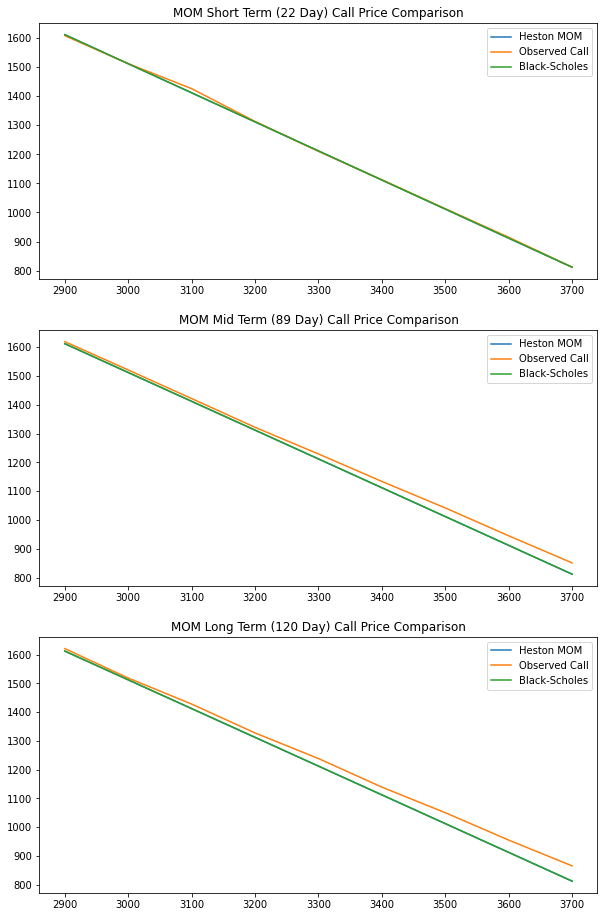

In [ ]:
plt.figure(figsize=(10,16))
axis1 = plt.subplot2grid((3, 1), (0, 0))
axis2 = plt.subplot2grid((3, 1), (1, 0))
axis3 = plt.subplot2grid((3, 1), (2, 0))

axis1.plot(list(list_K500_22),prices_MOM500[0:9], label= "Heston MOM")
axis1.plot(list(list_K500_22),actual_prices500[0:9], label = "Observed Call")
axis1.plot(list(list_K500_22),prices_BS500[0:9], label = "Black-Scholes")
axis1.set_title('MOM Short Term (22 Day) Call Price Comparison')

axis2.plot(list(list_K500_89),prices_MOM500[9:18], label= "Heston MOM")
axis2.plot(list(list_K500_89),actual_prices500[9:18], label = "Observed Call")
axis2.plot(list(list_K500_89),prices_BS500[9:18], label = "Black-Scholes")
axis2.set_title('MOM Mid Term (89 Day) Call Price Comparison')

axis3.plot(list(list_K500_120),prices_MOM500[18:], label= "Heston MOM")
axis3.plot(list(list_K500_120),actual_prices500[18:], label = "Observed Call")
axis3.plot(list(list_K500_120),prices_BS500[18:], label = "Black-Scholes")
axis3.set_title('MOM Long Term (120 Day) Call Price Comparison')

axis1.legend()
axis2.legend()
axis3.legend()
plt.show()

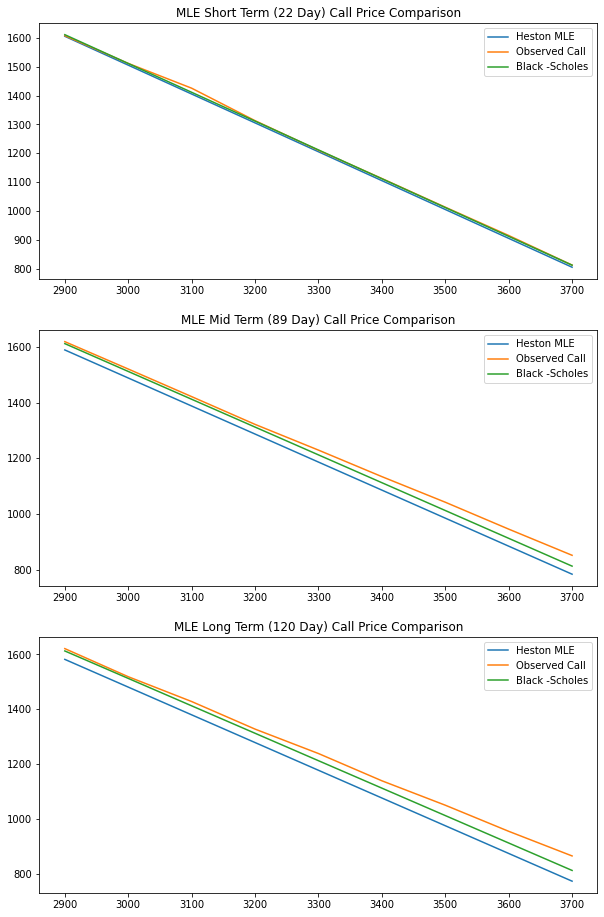

In [ ]:
plt.figure(figsize=(10,16))
axis1 = plt.subplot2grid((3, 1), (0, 0))
axis2 = plt.subplot2grid((3, 1), (1, 0))
axis3 = plt.subplot2grid((3, 1), (2, 0))

axis1.plot(list(list_K500_22),prices_MLE500[0:9], label= "Heston MLE")
axis1.plot(list(list_K500_22),actual_prices500[0:9], label = "Observed Call")
axis1.plot(list(list_K500_22),prices_BS500[0:9], label = "Black -Scholes")
axis1.set_title('MLE Short Term (22 Day) Call Price Comparison')

axis2.plot(list(list_K500_89),prices_MLE500[9:18], label= "Heston MLE")
axis2.plot(list(list_K500_89),actual_prices500[9:18], label = "Observed Call")
axis2.plot(list(list_K500_89),prices_BS500[9:18], label = "Black -Scholes")
axis2.set_title('MLE Mid Term (89 Day) Call Price Comparison')

axis3.plot(list(list_K500_120),prices_MLE500[18:], label= "Heston MLE")
axis3.plot(list(list_K500_120),actual_prices500[18:], label = "Observed Call")
axis3.plot(list(list_K500_120),prices_BS500[18:], label = "Black -Scholes")
axis3.set_title('MLE Long Term (120 Day) Call Price Comparison')

axis1.legend()
axis2.legend()
axis3.legend()
plt.show()

In [ ]:
#RMSE
#actual prices (observed)
actual500_22 = actual_prices500[0:9]
actual500_89 = actual_prices500[9:18]
actual500_120 = actual_prices500[18:]

#from BS
predicted_BS500_22= prices_BS500[0:9]
predicted_BS500_89= prices_BS500[9:18]
predicted_BS500_120= prices_BS500[18:]

rmse_BS500_22 = math.sqrt(metrics.mean_squared_error(actual500_22, predicted_BS500_22))
rmse_BS500_89 = math.sqrt(metrics.mean_squared_error(actual500_89, predicted_BS500_89))
rmse_BS500_120 = math.sqrt(metrics.mean_squared_error(actual500_120, predicted_BS500_120))

#from MOM
predicted_MOM500_22= prices_MOM500[0:9]
predicted_MOM500_89= prices_MOM500[9:18]
predicted_MOM500_120= prices_MOM500[18:]

rmse_MOM500_22 = math.sqrt(metrics.mean_squared_error(actual500_22, predicted_MOM500_22))
rmse_MOM500_89 = math.sqrt(metrics.mean_squared_error(actual500_89, predicted_MOM500_89))
rmse_MOM500_120 = math.sqrt(metrics.mean_squared_error(actual500_120, predicted_MOM500_120))

#from MLE
predicted_MLE500_22= prices_MLE500[0:9]
predicted_MLE500_89= prices_MLE500[9:18]
predicted_MLE500_120= prices_MLE500[18:]

rmse_MLE500_22 = math.sqrt(metrics.mean_squared_error(actual500_22, predicted_MLE500_22))
rmse_MLE500_89 = math.sqrt(metrics.mean_squared_error(actual500_89, predicted_MLE500_89))
rmse_MLE500_120 = math.sqrt(metrics.mean_squared_error(actual500_120, predicted_MLE500_120))

rmse_BS500_22 = math.sqrt(metrics.mean_squared_error(actual500_22, predicted_BS500_22))
print("RMSE for BS:" ,rmse_BS500_22,rmse_BS500_89,rmse_BS500_120)
print("RMSE for MOM:",rmse_MOM500_22,rmse_MOM500_89, rmse_MOM500_120)
print("RMSE for MLE:",rmse_MLE500_22,rmse_MLE500_89, rmse_MLE500_120)

RMSE for BS: 5.056809136643806 22.5644331992974 29.84973880189087
RMSE for MOM: 5.07156636388932 22.708153514223824 30.041348614201695
RMSE for MLE: 9.4717053249255 47.28717364293051 63.18500127037001
